# Hospital Data on Patient Discharges (2007-2013)

**Goals: Predict a patient's length of stay (LOS) and treatment completion result (1=complete/success, 0=not complete/failure) based on medical, demographic, and geographic information. Build two different classification models- one for LOS, one for treatment completion.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import math
import time

from sklearn.model_selection import (train_test_split,KFold)
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

/Users/daniellediehl/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data07=pd.read_csv("TEDS-D-2007-DS0001-data-excel.tsv", sep='\t')
data08=pd.read_csv("TEDS-D-2008-DS0001-data-excel.tsv", sep='\t')
data09=pd.read_csv("TEDS-D-2009-DS0001-data-excel.tsv", sep='\t')
data10=pd.read_csv("TEDS-D-2010-DS0001-data-excel.tsv", sep='\t')
data11=pd.read_csv("TEDS-D-2011-DS0001-data-excel.tsv", sep='\t')
data12=pd.read_csv("TEDS-D-2012-DS0001-data-excel.csv")

In [3]:
#Taking a sample of 1000 per year for shorter model training times
sample07=data07.sample(n=10000)
sample08=data08.sample(n=10000)
sample09=data09.sample(n=10000)
sample10=data10.sample(n=10000)
sample11=data11.sample(n=10000)
sample12=data12.sample(n=10000)

In [4]:
#Adding sample from all years to one dataframe
frames=[sample07,sample08,sample09,sample10,sample11,sample12]
full_data=pd.concat(frames)

**Data Pre-Processing**

In [5]:
#convert age to mean age--one less dummy
age_dict={2:13, 3:16, 4:19, 5:23, 6:27, 7:32, 8:37, 9:42, 10:47, 11:52, 12:55}
def group_age(s):
    if s in age_dict.keys():
        return age_dict[s]
full_data['AGE']=full_data['AGE'].map(group_age)

#delete CASEID column
del full_data['CASEID']

#update REASON column to just 0 or 1's
#updating reason column to just 1 and 0's 
def reason_func(s):
    if s==1:
        return 1
    else:
        return 0
    
##replace NANs with -9
full_data=full_data.replace(np.nan, '-9')

full_data['REASON']=full_data['REASON'].map(reason_func)
full_data['REASON'].value_counts()

0    32962
1    27038
Name: REASON, dtype: int64

In [6]:
#DUMMY VARIABLES
collist = full_data.columns.tolist()
#removing numeric and target variables before creating dummies
collist.remove('ARRESTS')
collist.remove('DAYWAIT')
collist.remove('NOPRIOR')
collist.remove('NUMSUBS')
collist.remove('AGE')
collist.remove('LOS')
collist.remove('REASON')
cat_df = full_data[collist]

#make these numbers strings so that get dummies will work
for i in cat_df.columns:
    cat_df[i]=cat_df[i].astype(str)

/Users/daniellediehl/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [7]:
#Because most of our variables are categorical variables that are coded numerically, 
#we decided to convert these to dummy variables.
df_with_dummies = pd.get_dummies( cat_df , prefix=cat_df.columns.tolist())

In [8]:
print "num of dummy columns", len(df_with_dummies.columns)
df_with_dummies.head()

num of dummy columns 887


,ALCDRUG_0,ALCDRUG_1,ALCDRUG_2,ALCDRUG_3,ALCFLG_0,ALCFLG_1,AMPHFLG_0,AMPHFLG_1,BARBFLG_0,BARBFLG_1,...,SUB3_5,SUB3_6,SUB3_7,SUB3_8,SUB3_9,TRNQFLG_0,TRNQFLG_1,VET_-9,VET_1,VET_2
417373,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1021897,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1256969,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
426395,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
729233,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [9]:
#add back the numeric columns (age, arrests, daywait, no prior, numsubs)
data=df_with_dummies
data['AGE']=full_data['AGE']
data['ARRESTS']=full_data['ARRESTS'].astype(int)
data['DAYWAIT']=full_data['DAYWAIT']
data['NOPRIOR']=full_data['NOPRIOR']
data['NUMSUBS']=full_data['NUMSUBS']
data['LOS']=full_data['LOS']
data['REASON']=full_data['REASON']

In [10]:
#Adjusting for missing values for the numeric variables
#--replacing the missing value (indicated by -9) with the mode of the variable
data['ARRESTS']=data['ARRESTS'].replace(-9,0)
data['DAYWAIT']=data['DAYWAIT'].replace(-9,0)
data['NOPRIOR']=data['NOPRIOR'].replace(-9,0)
data['NOPRIOR']=data['NOPRIOR'].replace(-9,0)

In [11]:
#Adjusting the LOS variable. According to the codebook, values 31 and above for LOS represent
#binned values for the number of days. For example, value 31 represented 31-45 number of days.
#We decided to bin the entire LOS variable with the below bins.

#bins: 1-15, 16-30, 31-45, 46-60, 61-90, 91-120, 121-180, 181-365, 366+

def fix_LOS(s):
    if s in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        return 1
    if s in [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
        return 2
    else:
        return s
data['LOS']=data['LOS'].map(fix_LOS)
data['LOS'].value_counts()

 1     20129
 2      7481
 36     6094
 33     5576
 35     5436
 34     4657
 31     4556
 32     3437
 37     2633
-9         1
Name: LOS, dtype: int64

In [12]:
#Creating target variables and splitting data into training and testing set
X=data[data.columns[data.columns!='LOS']]
X=X[X.columns[X.columns!='REASON']]
y_los=data['LOS']
y_r=data['REASON']

X_train, X_test, y_train_los, y_test_los = train_test_split(X,y_los,test_size = 0.33, random_state=42)
X_train, X_test, y_train_r, y_test_r = train_test_split(X,y_r,test_size = 0.33, random_state=42)

# Feature Extraction and Feature Selection Methods: Attempting to reduce dimensions of the dataset

**PCA: Principal Components Analysis**

In [28]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

X_train_scaled, X_test_scaled, y_train_los, y_test_los = train_test_split(X_scaled,y_los,test_size = 0.33, random_state=42)
X_train_scaled, X_test_scaled, y_train_r, y_test_r = train_test_split(X_scaled,y_r,test_size = 0.33, random_state=42)

In [29]:
#Scaling the data is important before performing PCA
#Without scaling, PCA will load more heavily on variables with greater variances.

pca=PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

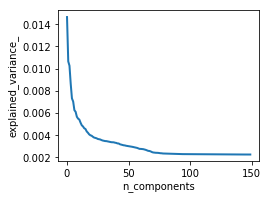

In [30]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_[:150], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [31]:
pca.explained_variance_ratio_.cumsum()[:320]

array([ 0.01465132,  0.02530148,  0.03556478,  0.04420477,  0.05152084,
        0.05855347,  0.06480497,  0.07090723,  0.07656572,  0.08205488,
        0.08746029,  0.09258456,  0.09747399,  0.10225761,  0.10687724,
        0.11143225,  0.11576797,  0.11998532,  0.12405688,  0.12804565,
        0.13199205,  0.13584882,  0.13963199,  0.14338447,  0.14710217,
        0.15075902,  0.15439723,  0.15800716,  0.16156309,  0.16507904,
        0.16856984,  0.17203565,  0.17549629,  0.17893381,  0.18233873,
        0.18573907,  0.18910371,  0.1924656 ,  0.19581781,  0.19913683,
        0.20243725,  0.20569115,  0.20893892,  0.21211694,  0.21526171,
        0.21837834,  0.22146511,  0.22453896,  0.22758206,  0.2306078 ,
        0.23361239,  0.2366026 ,  0.23957375,  0.24252266,  0.24544735,
        0.24834602,  0.25122929,  0.25407755,  0.25687852,  0.25963925,
        0.26239865,  0.26514467,  0.26787961,  0.27058636,  0.27325987,
        0.27589188,  0.2784754 ,  0.28104705,  0.28358058,  0.28

As you can see, 320 principal components explain about 80% of the variance in the data. Therefore, PCA reduced the dimension of the dataset from almost 900 variables to 320. However, because PCA is a feature extraction method that creates components based on a linear combination of the original features, interpretability is lost as a result.

In [32]:
#For the following models, when using the PCA components instead of the original feature space, 
#we used X_t_train and X_t_test
pca = PCA(n_components=320)
pca.fit(X_train_scaled)
X_t_train = pca.transform(X_train_scaled)
X_t_test = pca.transform(X_test_scaled)

**Randomized Logistic Regression**

In [33]:
#for reason: 
from sklearn.linear_model import RandomizedLogisticRegression

clf = RandomizedLogisticRegression()
clf.fit(X_train,y_train_r)

#Print the indices of the support features:
print clf.get_support(indices=True)

/Users/daniellediehl/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


[  1   2   4   5  15  78  81  86 112 127 142 145 166 185 186 205 220 238
 240 252 274 275 281 282 287 296 298 305 307 312 313 319 320 321 325 328
 330 331 333 335 337 345 352 353 356 363 380 389 407 408 409 416 433 434
 437 482 485 491 523 538 553 555 563 575 580 590 600 620 637 657 658 659
 661 672 682 700 702 704 710 713 718 720 722 724 725 726 736 737 738 739
 744 748 764 765 767 768 769 770 774 775 776 779 780 781 783 784 785 786
 788 790 791 794 796 797 799 804 806 807 810 811 812 813 814 820 821 835
 839 865 892 893]


In [34]:
#According to Logistic Regression, which features are important in predicting treatment result?
f='  1   2   4   5  51  56  69  81  90  99 113 128 145 148 152 167 186 230 \
 239 240 271 279 280 283 289 290 298 300 307 309 319 321 322 323 330 333 \
 335 337 347 351 354 358 360 365 369 370 391 408 409 410 411 413 435 436 \
 439 440 451 457 460 473 482 495 507 525 544 557 559 565 583 603 644 649 \
 659 684 702 705 706 712 715 720 726 727 728 738 739 741 746 750 766 767 \
 769 770 771 772 777 778 781 783 785 786 787 790 792 793 796 798 799 801 \
 806 809 810 815 816 817 822 823 837 841 847 867 891 894 895'
a=[]
for i in f.split():
    i=int(i)
    a.append(i)

In [ ]:
#use X_train_lr in later models to run only on the selected subset
data_lr = data.iloc[:,a]
X_lr=data_lr
y_los=data['LOS']
y_r=data['REASON']

X_train_lr, X_test_lr, y_train_los, y_test_los = train_test_split(X_lr,y_los,test_size = 0.33, random_state=42)
X_train_lr, X_test_lr, y_train_r, y_test_r = train_test_split(X_lr,y_r,test_size = 0.33, random_state=42)

In [ ]:
#which columns are important? #123 columns
print data_lr.columns[:40] 
#alcdrug, alcflags, CBSA (geo area), detcrim (detailed criminal justice report)
#detnlf, division, dsm diagnosis, educ, emp, freq
print data_lr.columns[41:80]
#age of first use, flags, insurance, PMSA geo area, income source, pay source, source of ref
print data_lr.columns[81:]
#psy info, race, region, treatment route, service, stfips, substance, age, noprior, numsubs

In [ ]:
#for LENGTH OF STAY
clf = RandomizedLogisticRegression()
clf.fit(X_train,y_train_los)

#Print the indices of the support features:
print clf.get_support(indices=True)

In [ ]:
g='21  34  47  63  66  67  78 111 120 126 147 164 165 176 178 199 229 231 \
277 278 281 282 283 286 288 291 292 293 298 300 301 303 304 305 306 320 \
322 333 334 336 346 347 349 350 352 356 407 408 416 421 422 424 425 434 \
435 467 470 471 482 518 521 522 531 559 561 578 579 587 589 592 626 649 \
703 711 720 721 722 725 726 741 742 743 744 747 766 767 768 769 770 771 \
772 773 786 791 792 794 799 800 801 804 806 809 810 814 816 818 840 841 \
843 888 890 891'
b=[]
for i in g.split():
    i=int(i)
    b.append(i)

In [ ]:
len(b)
#112 variables for predicting LOS

In [ ]:
#which columns are important? #112 columns
print data_lr_los.columns[:40] 
#alcdrug, alcflags, CBSA (geo area), detcrim (detailed criminal justice report)
#detnlf, division, dsm diagnosis, educ, emp, freq
print data_lr_los.columns[41:80]
#age of first use, flags, insurance, PMSA geo area, income source, pay source, source of ref
print data_lr_los.columns[81:]
#psy info, race, region, treatment route, service, stfips, substance, age, noprior, numsubs

In [ ]:
#use X_train_lr in later models to run only on the selected subset
data_lr_los = data.iloc[:,b]
X_lr_los=data_lr_los
y_los=data['LOS']
y_r=data['REASON']

X_train_lr_los, X_test_lr_los, y_train_los, y_test_los = train_test_split(X_lr_los,y_los,test_size = 0.33, random_state=42)

## Length of Stay

**SVM: Support Vector Machines**

Comparing training time for SVM models based on original feature space, PCA feature space, and the reduced feature space from logistic regression.

In [17]:
start=time.clock()
svm_model_linear = SVC(kernel = 'linear', C = 1)

svm_model_linear.fit(X_train, y_train_los)

score=svm_model_linear.score(X_test,y_test_los)
print score
print "Time: ", time.clock() - start, ' seconds'

0.405606060606
Time:  7533.04286  seconds


In [25]:
start=time.clock()
svm_model_linear = SVC(kernel = 'linear', C = 1)

svm_model_linear.fit(X_t_train, y_train_los)

score=svm_model_linear.score(X_t_test,y_test_los)
print score
print "Time: ", time.clock() - start, ' seconds'

0.402828282828
Time:  20683.008772  seconds


In [22]:
start=time.clock()

svm_model_linear = SVC(kernel = 'linear', C = 1)

svm_model_linear.fit(X_train_lr_los, y_train_los)

score=svm_model_linear.score(X_test_lr_los,y_test_los)

print score
print "Time: ", time.clock() - start, ' seconds'

0.396161616162
Time:  2181.84953  seconds


**Random Forests**

In [33]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=0, max_features=30, max_depth=7)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train_los)

# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
#clf.predict(X_test)

# Create actual english names for the plants for each predicted plant class
#preds = clf.predict(X_test)

# View a list of the features and their importance scores

#print 'train', clf.score(X_train_los, y_train_los, sample_weight=None)

print 'test', clf.score(X_test, y_test_los, sample_weight=None)

test 0.354595959596


**MLP: Multi-Layered Perceptron**

Comparing MLP models based on original feature space, PCA feature space, and reduced feature space from logistic regression.

In [31]:
start=time.clock()

mlp= MLPClassifier(alpha=1e-1, hidden_layer_sizes=(15,), random_state=1)
mlp.fit(X_train, y_train_los) 
print mlp.score(X_test,y_test_los)

print "Time: ", time.clock() - start, ' seconds'
#Why am I now getting 20%??

0.396515151515
Time:  46.247193  seconds


In [30]:
start=time.clock()

#with pca
mlp= MLPClassifier(alpha=1e-1, hidden_layer_sizes=(15,), random_state=1)

mlp.fit(X_t_train, y_train_los)
#predictions = pipe.predict(features_valid)
score=mlp.score(X_t_test,y_test_los)
print score

print "Time: ", time.clock() - start, ' seconds'

0.394191919192
Time:  25.041265  seconds


In [32]:
start=time.clock()

#with pca
mlp= MLPClassifier(alpha=1e-1, hidden_layer_sizes=(15,), random_state=1)

mlp.fit(X_train_lr_los, y_train_los)
#predictions = pipe.predict(features_valid)
score=mlp.score(X_test_lr_los,y_test_los)
print score

print "Time: ", time.clock() - start, ' seconds'

0.39398989899
Time:  6.652829  seconds


**KNN: K Nearest Neighbors**

Comparing KNN model based on original feature space, PCA, and logistic regression

In [ ]:
start=time.clock()

knn=neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train_los)
print knn.score(X_test,y_test_los)

print "Time: ", time.clock() - start, ' seconds'

0.341818181818
Time:  234.620227  seconds


In [37]:
start=time.clock()

knn=neighbors.KNeighborsClassifier()

knn.fit(X_t_train, y_train_los)

score=knn.score(X_t_test,y_test_los)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.350656565657
Time:  451.860937  seconds


In [35]:
start=time.clock()

knn=neighbors.KNeighborsClassifier()

knn.fit(X_train_lr_los, y_train_los)

score=knn.score(X_test_lr_los,y_test_los)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.359595959596
Time:  29.173775  seconds


**XGBoost**

In [ ]:
#XGBOOST- LOS
model = XGBClassifier(objective='multi:softmax')#,num_class=9)
model.fit(X_train_los, y_train_los)

y_pred = model.predict(X_test_los)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print accuracy

# Models for Predicting Treatment Completion (Reason)

**Logistic Regression**

In [35]:
start = time.clock()
logreg = linear_model.LogisticRegression(penalty='l2',C=1e5)
#solver=‘newton-cg’
# Train the model using the training sets
logreg.fit(X_train, y_train_r)
#y_pred = regr.predict(X_test)
print logreg.score(X_test,y_test_r)
print "Time: ", time.clock() - start, ' seconds'

0.683787878788
Time:  24.845636  seconds


In [61]:
start = time.clock()

#pca = PCA(n_components=320)
clf = linear_model.LogisticRegression(penalty='l2',C=1e5) 

#pipe = Pipeline([('pca', pca), ('logistic', clf)])
clf.fit(X_t_train, y_train_r)

score=clf.score(X_t_test,y_test_r)
print score 
print "Time: ", time.clock() - start, ' seconds'

0.65803030303
Time:  28.057315  seconds


In [26]:
#LR subset
start = time.clock()

clf = linear_model.LogisticRegression(penalty='l2',C=1e5) 

clf.fit(X_train_lr, y_train_r)

score=clf.score(X_test_lr,y_test_r)
print score 
print "Time: ", time.clock() - start, ' seconds'

0.685
Time:  1.507366  seconds


**SVM: Support Vector Machine**

In [24]:
print data['REASON'].value_counts()
print 32771/float((32771+27229))

0    32771
1    27229
Name: REASON, dtype: int64
0.546183333333


In [32]:
start=time.clock()

svm2 = svm.SVC(gamma=0.001, C=100.)
svm2.fit(X_train, y_train_r)  
#svm2.predict(X_test_r)
print svm2.score(X_test, y_test_r)
#scaling the data decreased the score from 68 to 65 

print "Time: ", time.clock() - start, ' seconds'

0.688181818182
Time:  8431.688482  seconds


In [31]:
start=time.clock()

#with PCA
pca = PCA(n_components=320)
svc = svm.SVC(gamma=0.001, C=100.)

pipe = Pipeline([('pca', pca), ('svm', svc)])
pipe.fit(X_train_scaled, y_train_r)
#predictions = pipe.predict(features_valid)
score=pipe.score(X_test_scaled,y_test_r)
print score #similar for SVM

print "Time: ", time.clock() - start, ' seconds'

0.560101010101
Time:  228.139003  seconds


**Random Forests**

In [28]:
start=time.clock()
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=0, max_features=40, max_depth=9)

clf.fit(X_train, y_train_r)

print 'test', clf.score(X_test, y_test_r, sample_weight=None)

print "Time: ", time.clock() - start, ' seconds'

test 0.654444444444
Time:  1.572092  seconds


In [27]:
#LR subset
start=time.clock()
clf = RandomForestClassifier(random_state=0, max_features=40, max_depth=9)

clf.fit(X_train_lr, y_train_r)

print 'test', clf.score(X_test_lr, y_test_r, sample_weight=None)
print "Time: ", time.clock() - start, ' seconds'

test 0.68202020202
Time:  1.137784  seconds


**MLP: Multi-Layered Perceptron**

In [26]:
model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15,), random_state=1, alpha=1)
model.fit(X_train_r_scaled, y_train_r)
model.score(X_test_r_scaled,y_test_r)

0.64080808080808083

In [63]:
start=time.clock()

mlp= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
mlp.fit(X_train, y_train_r)
print mlp.score(X_test,y_test_r)

print "Time: ", time.clock() - start, ' seconds'

0.679191919192
Time:  186.033874  seconds


In [62]:
start=time.clock()
#with PCA

mlp= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

mlp.fit(X_t_train, y_train_r)

score=mlp.score(X_t_test,y_test_r)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.666919191919
Time:  41.009491  seconds


In [29]:
#LR subset
start=time.clock()

mlp= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

mlp.fit(X_train_lr, y_train_r)

score=mlp.score(X_test_lr,y_test_r)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.677272727273
Time:  24.916902  seconds


**KNN: K-Nearest Neighbors**

In [65]:
start=time.clock()

knn=neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train_r)
print knn.score(X_test, y_test_r)

print "Time: ", time.clock() - start, ' seconds'

0.612575757576
Time:  251.798702  seconds


In [64]:
start=time.clock()
#with PCA
knn=neighbors.KNeighborsClassifier()

knn.fit(X_t_train, y_train_r)

score=knn.score(X_t_test,y_test_r)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.634343434343
Time:  415.900131  seconds


In [31]:
#LR subset
start=time.clock()
#with PCA
knn=neighbors.KNeighborsClassifier()

knn.fit(X_train_lr, y_train_r)

score=knn.score(X_test_lr,y_test_r)
print score 

print "Time: ", time.clock() - start, ' seconds'

0.628535353535
Time:  22.076013  seconds


**XGBOOST**

Comparing XGBoost accuracy and training time for models based on original feature space, PCA, and reduced set from logistic regression.

In [70]:
#XGBOOST- reason
start=time.clock()

model = XGBClassifier()
model.fit(X_train, y_train_r)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print accuracy

print "Time: ", time.clock() - start, ' seconds'

0.685101010101
Time:  99.946485  seconds


In [69]:
#XGBOOST- reason, PCA
start=time.clock()

model = XGBClassifier()
model.fit(X_t_train, y_train_r)
y_pred=model.predict(X_t_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print accuracy

print "Time: ", time.clock() - start, ' seconds'

0.658333333333
Time:  109.323209  seconds


In [33]:
#XGBOOST- reason, LR subset
start=time.clock()

model = XGBClassifier()
model.fit(X_train_lr, y_train_r)
y_pred=model.predict(X_test_lr)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print accuracy

print "Time: ", time.clock() - start, ' seconds'

0.688484848485
Time:  14.387172  seconds


In [24]:
param_grid_xg={'learning_rate': [0.05, 0.1, 0.3],
        'max_depth': [3, 6, 10],
        'subsample': [0.6, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.9, 1.0]}
grid_xg = GridSearchCV(XGBClassifier(),param_grid_xg,refit=True)
grid_xg.fit(X_train, y_train_r)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.9, 1.0], 'learning_rate': [0.05, 0.1, 0.3], 'colsample_bytree': [0.6, 0.9, 1.0], 'max_depth': [3, 6, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
#XGBClassifier().get_params().keys()

In [27]:
y_pred=grid_xg.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print accuracy

0.702929292929


**Gradient Boosting Classifier**

In [37]:
gbc=GradientBoostingClassifier(learning_rate=0.3, n_estimators=175, max_depth = 7)
gbc=gbc.fit(X_train, y_train_r)
sc_val = gbc.score(X_test, y_test_r)
sc_val

0.69030303030303031

In [14]:
#Defining the initial parameter grid to search in
param_grid = {'learning_rate': [0.01,.1], 'n_estimators': [100, 200], 'max_depth': [5,10]}

In [15]:
grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True)
grid.fit(X_train,y_train_r)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
grid.score(X_test, y_test_r)

0.70151515151515154

In [13]:
param_grid = {'learning_rate': [0.01, 0.001, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [3, 5,10]}
grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True)
grid.fit(X_train,y_train_r)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.001, 0.1], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
grid.score(X_test, y_test_r)

0.69898989898989894